In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Minimint

Minimint is an even more bare-bone version of [Spearmint-lite](https://github.com/JasperSnoek/spearmint/).
Besides being compatible with Python 3, the idea is to provide a 
simple Class to be used in Bayesian Hyperparameters Optimization.

I provide the class MinimintOptimizer that does the book keeping of the sampled hyperparameters sets and proposes new points to sample using the Spearmint-lite algorithms.

It does not handle any managing of tasks or results and therefor can be combined with any job management framework.
Below I present a simple example of using Minimint together with [Ipyparallel](https://github.com/ipython/ipyparallel).



# Example random function

We start with our target function which is just a 2D Gaussian mixture with random centers and variances.

<IPython.core.display.Javascript object>


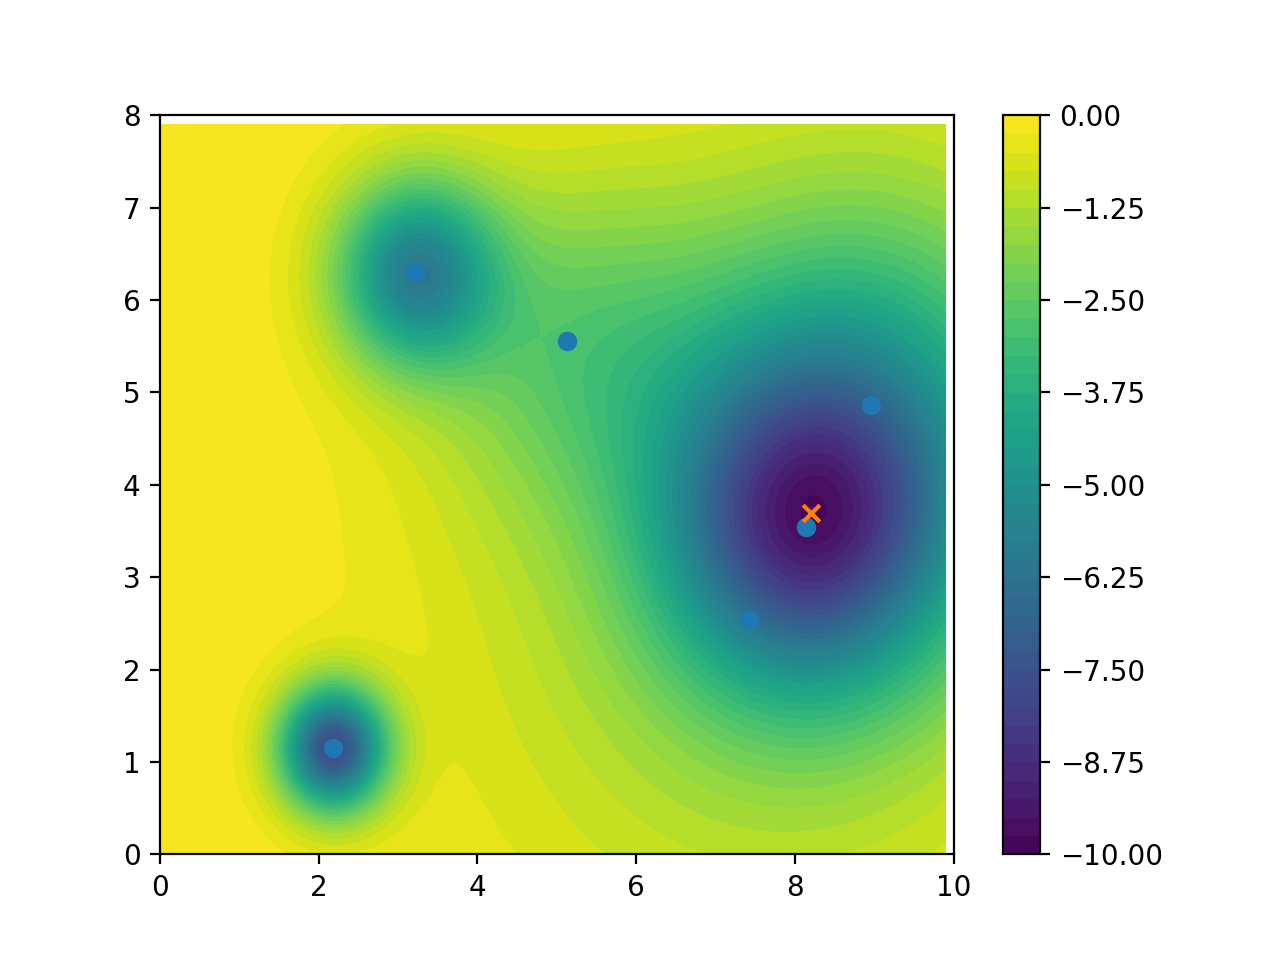

(0, 8)

In [2]:
class random2DGausianMixture(object):
    def __init__(self,xyrange,n,sigma):
        self.centers = [(xyrange[0]*rand(),xyrange[1]*rand()) for i in range(n)]
        self.amplitudes = 10*rand(n)
        self.sigmas = 0.3*np.mean(xyrange)*rand(n)
        self.noise_sigma = sigma
        
    def G(self,r,center,sigma,amp):
        return amp*np.exp(-np.sum((r-center)**2)/(2*sigma**2))
    
    def __call__(self,r):
        gs = [self.G(r,c,s,a) \
                    for c,s,a in zip(self.centers,self.sigmas,self.amplitudes)]
        return -np.sum(gs) + self.noise_sigma*randn()

#create a function on x in [0,10] and y in [0,8] with 6 centers and no noise.
f = random2DGausianMixture((10,8),6,0.)


# plot the example function with the center and minimum
@vectorize
def vec_f(x,y):
    return f(array((x,y)))

x=arange(0,10,.1)
y=arange(0,8,.1)
X,Y = meshgrid(x,y)
F=vec_f(X,Y)
xc=array([c[0] for c in f.centers])
yc=array([c[1] for c in f.centers])

close()
#ploting the function
contourf(X,Y,F,40)
colorbar()
#gauusian centers
scatter(xc,yc)
#global minimum
real_min_ind = argmin(F.flatten())
scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x')
xlim(0,10)
ylim(0,8)

In [3]:
#set noise level for simulation
f.noise_sigma=0.5

# Plotting

We first define some plotting functions to have some fun graphics during the simulation

In [4]:

from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

def init_plot():
    #XY = array([HO.gmap.unit_to_list(c) for c in HO.complete])
    XY_pending = array([HO.gmap.unit_to_list(c) for c in HO.pending])
    ms=5
    close()
    fig=figure(figsize=[18/2,12/2])
    ax1=subplot(121)
    cont1=contourf(X,Y,F,20)
    l_complete = plot([],[],ls='none',marker='o',ms=ms,color='b')
    l_pending = plot(XY_pending[:,0],XY_pending[:,1],ls='none',marker='o',ms=ms,color='0.5')
    #best_run = argmin(HO.values)
    l_best = plot([],[],ls='none',marker='o',ms=ms,color='r')
    real_min_ind = argmin(F.flatten())
    scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x',color='g')
    xlim(-1,11)
    ylim(-1,9)
    

    ax2=subplot(122)
    xlim(-1,11)
    ylim(-1,9)

    tight_layout()
    fig.canvas.draw()
    return fig,ax1,ax2,l_complete[0],l_pending[0],l_best[0]


def update_plot():
    XY = array([HO.gmap.unit_to_list(c) for c in HO.complete])
    XY_pending = array([HO.gmap.unit_to_list(c) for c in HO.pending])
    
    if len(HO.values)>0:
        l_complete.set_data(XY[:,0],XY[:,1])
        best_run = argmin(HO.values)
        l_best.set_data(XY[best_run,0],XY[best_run,1])
    if len(HO.values)>3:
        Xx, Yy, Zz = grid(XY[:,0],XY[:,1],array(HO.values))
        ax2.clear()
        ax2.contourf(Xx, Yy, Zz,20)
        ax2.scatter(XY[best_run,0],XY[best_run,1],color='r')
        ax2.set_xlim(-1,11)
        ax2.set_ylim(-1,9)
    if len(XY_pending)>0:
        l_pending.set_data(XY_pending[:,0],XY_pending[:,1])
    else:
        l_pending.set_data([],[])
    
    fig.canvas.draw()
    plt.draw_all()

## Ipyparallel setup

In [5]:
import ipyparallel as ipp
#creating a client direct view and load balance view
ipp_client = ipp.Client()
ipp_dview = ipp_client.direct_view()
ipp_lbview = ipp_client.load_balanced_view()

/usr/local/lib/python3.6/dist-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@parker')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Some remote imports on theh engiens

In [6]:
%%px
import time
import numpy as np
from numpy.random import rand, randn

send the target function to all engine

In [7]:
a=ipp_dview.push({'random2DGausianMixture':random2DGausianMixture})
a=ipp_dview.push({'f':f})
a.get()

[None, None, None, None, None, None, None, None]

Define the function we will use to run the "simulation" on the engines.

In [8]:
import time

def run_job(params,job_id):
    '''
    this function takes parameters from the MinimintOptimizer and runs a simulation 
    with those parameters.
    it should return the job_id as well so that the MinimintOptimizer will be 
    able to asociate the results with the right parameters.
    '''
    # process the parameters 
    x = params[0]
    y = params[1]
    
    # run 'simulation'
    val = f(np.array((x,y)))
    dur = 30*np.random.rand()
    time.sleep(dur)
    
    # return results 
    return job_id,val,dur

# Setup for Minimint

In [9]:
from minimint.MinimintOptimizer import MinimintOptimizer
# two supported choosers
from minimint.chooser.GPEIChooser import GPEIChooser
from minimint.chooser.GPEIOptChooser import GPEIOptChooser

#define the hyperparameters we want to optimize
variables = {
"X" : {
  "name":"X",
  "type":"float",
  "min":0,
  "max":10,
  "size":1
},
"Y" : {
  "name":"Y",
  "type":"float",
  "min":0,
  "max":8,
  "size":1
}
}


#create chooser and optimizer. 
chooser = GPEIChooser()
HO = MinimintOptimizer(variables,chooser,init_grid_size = 20,grid_size = 1000)

# generate initial parameters to submit
init_params = [HO.gmap.unit_to_list(u) for u in HO.pending]



# Optimization using Ipyparaller and Minimint

<IPython.core.display.Javascript object>


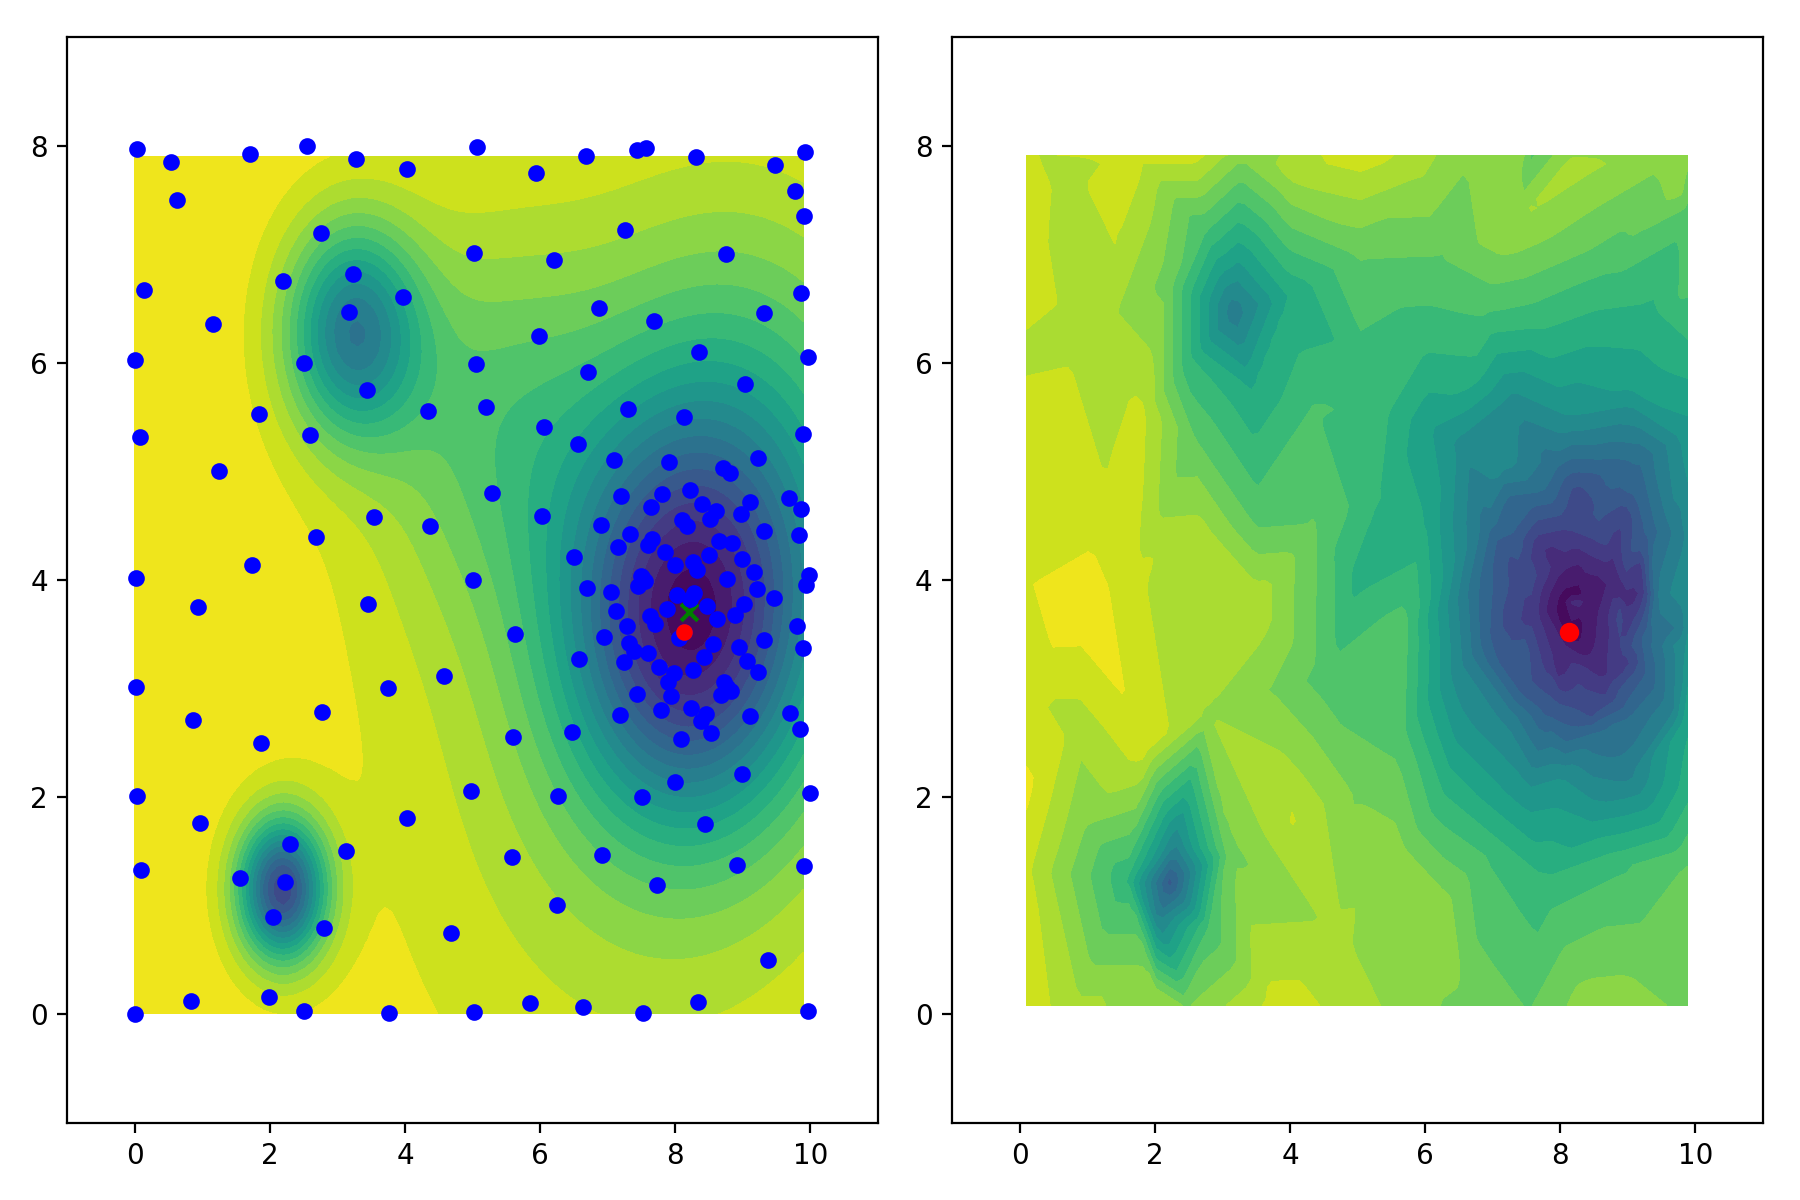

In [10]:
# Show a plot to monitor the simulation
fig,ax1,ax2,l_complete,l_pending,l_best=init_plot() 

In [11]:
#this bit is adapted from ipyparallel examples
#we wait for tasks to complete and submit new tasks according to the suggestions of the MinimintOptimizer

def unwrap_async_result(msg_id):
    # we know these are done, so don't worry about blocking
    ar = ipp_client.get_result(msg_id)
    #sometimes returns list with one tuple 
    result = ar.get()
    if type(result)==list:
        result = result[0]
    return result
    
# submit jobs of initial grid
amr = ipp_lbview.map_async(run_job,init_params,HO.pending_job_id)

# a set of jobs tasks to track
pending = set(amr.msg_ids)
# total number of sampled point
n_jobs=len(pending)
# maximum number of points to sample
max_n_jobs=200
#maximum_number of pending jobs ()
max_pending = 25
# time between result checks
wait_time = 1e-2

while pending:
    try:
        ipp_client.wait(pending, wait_time)
    except ipp.TimeoutError:
        # ignore timeouterrors, since they only mean that at least one isn't done
        pass
    
    # finished is the set of msg_ids that are complete
    finished = pending.difference(ipp_client.outstanding)
    # update pending to exclude those that just finished
    pending = pending.difference(finished)
 
    # handle the results 
    for msg_id in finished:
        r = unwrap_async_result(msg_id)
        job_id,val,dur = r
        # notify the MinimintOptimizer of the job that finished and the results
        HO.process_result(job_id,val,dur)
        # If needed do some post processing of results
        print('Recieved results job_id={}, value={}, duration={}'.format(job_id,val,dur))
        
    # Now add a new point from the chooser    
    if n_jobs <= max_n_jobs: 
        if len(HO.pending)< max_pending:
            n_jobs += 1
            #get new set of hyperparametes
            new_job_id,new_params = HO.find_next_point()
            #submit job to ipcluster
            ar = ipp_lbview.apply_async(run_job,new_params,new_job_id) 
            # adding new job to tracking list
            pending.add(ar.msg_ids[0])
            # If needed do some post processing after submiting the job
            print('Submited Minimint job id {} with ipcluster id {}. Total of {} pending tasks'\
                  .format(new_job_id,ar.msg_ids[0],len(HO.pending)))
            update_plot()
            
#finally plot the final results           
update_plot()

Submited Minimint job id 20 with ipcluster id a5390fb2-8447969cc19943fa045c30b6. Total of 21 pending tasks
Recieved results job_id=4, value=-1.258585499471299, duration=0.21018998599340755
Submited Minimint job id 21 with ipcluster id 2e9af3e4-010435f41c5ed7d942e6cac6. Total of 21 pending tasks
Submited Minimint job id 22 with ipcluster id b21ab2a2-9fe93e5fc11977963891cf31. Total of 22 pending tasks
Submited Minimint job id 23 with ipcluster id 686163b8-57119cec9b822394bf26ddb9. Total of 23 pending tasks
Submited Minimint job id 24 with ipcluster id f39c3eff-cc7e3e4519cad521d06c2f74. Total of 24 pending tasks
Submited Minimint job id 25 with ipcluster id f81b8a44-fee21d0b5aeee77d4c665e5b. Total of 25 pending tasks
Recieved results job_id=7, value=-0.010002968725814049, duration=3.873670683099127
Submited Minimint job id 26 with ipcluster id e959c0da-7d4ee4cf5fdbb18cb29128dc. Total of 25 pending tasks
Recieved results job_id=9, value=-2.2889198655089746, duration=0.012877117381348002
Su